# CUCAI Graphs

## Helper Functions

In [3]:
import torch 
import tensorflow as tf
import torch.nn as nn
import numpy as np
import gym
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data


In [4]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

  
    def training_step(self, batch, batch_idx):
        """
        We're doing a two-phase approach:
          1) Burn-in the hidden state by passing the entire 'x' sequence
             one time-step at a time (without using 'a').
          2) Predict the next 'p_length' steps, each time feeding CfC its
             own previous output plus the action.
        """
        x, a, y = batch
    
        B = x.size(0)
        t_length = x.size(1)  # length of the 'burn-in' sequence
        p_length = y.size(1)  # length of the 'prediction' sequence
    
        # Initialize hidden state (h, c) for CfC with mixed_memory
        h0 = torch.zeros((B, self.model.state_size), device=x.device)
        c0 = torch.zeros((B, self.model.state_size), device=x.device)
        hx = (h0, c0)
    
        # ---------------------------
        # 1) Burn-in phase
        # ---------------------------
        # We feed one time-step at a time => shape (B, 1, x_dim)
        for i in range(t_length):
            _, hx = self.model(x[:, i : i+1, :], hx)
    
        # ---------------------------
        # 2) Predict forward
        # ---------------------------
        
        predictions = []
        # Our 'current input' is the last piece of 'x' or the last hidden output.
        # But since your code does: "cur_input = x[:, -1, :]" at first, we can do:
        cur_input = x[:, -1:, :]  # shape (B, 1, x_dim)
    
        for i in range(p_length):
            # out => (B, output_dim) because return_sequences=False
            out, hx = self.model(cur_input, hx)
    
            # Save output at this step => shape (B, 1, output_dim)
            predictions.append(out.unsqueeze(1))
    
            # Build next input => (B, output_dim + a_dim)
            # a[:, i, :] => shape (B, a_dim)
            # out => shape (B, output_dim)
            next_input = torch.cat([out, a[:, i, :]], dim=-1)  # => (B, output_dim + a_dim)
    
            # CfC wants 3D => (B, 1, out_dim+a_dim)
            cur_input = next_input.unsqueeze(1)
    
        # Combine predictions => shape (B, p_length, output_dim)
        predictions = torch.cat(predictions, dim=1)
    
        # Compare with y => shape (B, p_length, output_dim)
        # Make sure y has the same last dimension (output_dim)
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

        
            
    def validation_step(self, states, actions, new_states, batch_idx):
        
        x, a, y = batch
        #states, actions = x
        
        #rolling_inputs = torch.concatenate((states, actions[:, :states.shape[1], :]), axis=-1)
        
        predictions = []
        h = torch.zeros((x.shape[0], self.model.state_size)).to(self.model.device())
        
        for i in range(self.length):
            
            prediction, h = self.model.forward(rolling_inputs, h)
            prediction = prediction.unsqueeze(axis=1)
            predictions.append(prediction)
            prediction = torch.concatenate((prediction, a[:, i, :]), axis=-1)
            #new_sa = torch.concatenate((prediction, actions[:, states.shape[1]+i: states.shape[1]+1+1, :]), axis=-1)
            #rolling_inputs = torch.concatenate((rolling_inputs, new_sa), axis=1)
        
        
        predictions = torch.stack(predictions)
        predictions = torch.swapaxes(predictions, 0, 1)
        print(predictions.shape, " ", y.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        loss = nn.L1Loss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        B, t_length, _ = batch.shape
        h0 = torch.zeros((B, self.model.state_size))
        c0 = torch.zeros((B, self.model.state_size))
        hx = (h0, c0)
        
        for i in range(t_length):
            pred, hx = self.model(batch[:, i : i+1, :], hx)

        return pred
    
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [5]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [6]:
angular_velocity = 2
max_angular_velocity_magnitude = 8
def get_rnd_env_samples(env, num_rollouts, scale_vel = True):
    
    t_obs = []
    t_a = []
    t_n_obs = []
    for _ in range(num_rollouts):
        
        observation, info = env.reset()
        
        terminated = False
        truncated = False
    
        c_obs = []
        c_a = []
        c_n_obs = []
        
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
            obs = observation
            v_obs = torch.FloatTensor(observation)
    
            action = env.action_space.sample()
        
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            c_obs.append(obs)
            c_a.append(action)
            c_n_obs.append(observation)
       
        # Once the episode is done, close the environment
        #env.close()
    
        t_obs.append(np.vstack(c_obs))
        t_a.append(np.vstack(c_a))
        t_n_obs.append(np.vstack(c_n_obs))
    
    env.close()
    
    t_obs = np.stack(t_obs)
    t_a = np.stack(t_a)
    t_n_obs = np.stack(t_n_obs)
    
    #t_obs.shape
    #t_a.shape
    if scale_vel == True:
        t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
        t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
    
    #inputs = np.concatenate((t_obs, t_a), axis=2)

    return t_obs, t_a, t_n_obs

In [7]:
def residual_plot(outputs: np.array, residuals:np.array, title:str) -> None:
    fig,ax = plt.subplots(3,1,figsize=(14,8))
    ax[0].set_title(title)
    ax[0].scatter(outputs[:,0],residuals[:,0],label='x error',alpha=0.2)
    ax[1].scatter(outputs[:,1],residuals[:,1],label='y error',alpha=0.2)
    ax[2].scatter(outputs[:,2]*max_angular_velocity_magnitude,residuals[:,2],label='velocity error',alpha=0.2)
    for i in range(3):
      ax[i].legend()
      ax[i].grid(alpha=0.5)
      ax[i].axhline(0,ls='--',c='k')
      ax[i].set_xlabel('true value')
      ax[i].set_ylabel('prediction error')
    plt.tight_layout()

## Train Models

### NCPS

In [8]:
import gym
num_rollouts = 100 # 100 * 200 = 20,000 training samples. should be fine..? 
env = gym.make("Pendulum-v1")

In [37]:
num_rollouts = 200
s, a, n_s = get_rnd_env_samples(env, num_rollouts)
s = s[:, :, 0:2]
n_s = n_s[:, :, 0:2]
s = np.concatenate((s, a), axis=-1)
s.shape

(200, 200, 3)

In [10]:
import numpy as np

import numpy as np

def prepare_data(
    s,            # shape: (batch_size, T, state_dim)
    a,            # shape: (batch_size, T, action_dim)
    n_s,          # shape: (batch_size, T, next_state_dim)
    trajectory_length,
    projection_length
):
    """
    s:  (batch_size, T, state_dim) array of states
    a:  (batch_size, T, action_dim) array of actions
    n_s:(batch_size, T, next_state_dim) array of 'next states'
        at each time step.

    trajectory_length: Number of time steps to use as input sequence (data_x, data_a)
    projection_length: Number of time steps to predict into the future (data_y)

    Returns
    -------
    data_x: shape (batch_size * num_windows, trajectory_length, state_dim)
    data_a: shape (batch_size * num_windows, trajectory_length, action_dim)
    data_y: shape (batch_size * num_windows, projection_length, next_state_dim)
    """

    batch_size, T, state_dim = s.shape
    _, _, action_dim = a.shape
    _, _, next_state_dim = n_s.shape

    # The maximum index we can start a window at is:
    # i + trajectory_length + projection_length - 1 <= T - 1
    # => i <= T - (trajectory_length + projection_length)
    num_windows = T - (trajectory_length + projection_length) + 1
    if num_windows <= 0:
        raise ValueError(
            "trajectory_length + projection_length must be smaller than (or at most equal to) T."
        )

    # We will create 4D arrays of shape:
    #   (batch_size, num_windows, trajectory_length, state_dim)
    # etc., and then later reshape into 3D for the final return.
    data_x_4d = np.zeros((batch_size, num_windows, trajectory_length, state_dim),
                         dtype=s.dtype)
    data_a_4d = np.zeros((batch_size, num_windows, projection_length, action_dim),
                         dtype=a.dtype)
    data_y_4d = np.zeros((batch_size, num_windows, projection_length, next_state_dim),
                         dtype=n_s.dtype)

    # Slide over time dimension
    for i in range(num_windows):
        # 1) data_x = states from i to i + trajectory_length - 1
        data_x_4d[:, i, :, :] = s[:, i : i + trajectory_length, :]

        # 2) data_a = actions from i to i + trajectory_length - 1
        data_a_4d[:, i, :, :] = a[:, i : i + projection_length, :]

        # 3) data_y = next states from i+trajectory_length to i+trajectory_length+projection_length-1
        start_y = i + trajectory_length
        end_y   = i + trajectory_length + projection_length
        data_y_4d[:, i, :, :] = n_s[:, start_y : end_y, :]

    # Finally, merge batch and window dimensions: (batch_size * num_windows, ...)
    data_x = data_x_4d.reshape(-1, trajectory_length, state_dim)
    data_a = data_a_4d.reshape(-1, projection_length, action_dim)
    data_y = data_y_4d.reshape(-1, projection_length, next_state_dim)

    return data_x, data_a, data_y

# Example usage:
trajectory_length = 3
projection_length = 2

data_x, data_a, data_y = prepare_data(s, a, n_s, trajectory_length, 1)
print("data_x shape:", data_x.shape)  # (batch_size*num_windows, 3, state_dim)
print("data_a shape:", data_a.shape)  # (batch_size*num_windows, 3, action_dim)
print("data_y shape:", data_y.shape)  # (batch_size*num_windows, 2, next_state_dim)


data_x shape: (19700, 3, 3)
data_a shape: (19700, 1, 1)
data_y shape: (19700, 1, 2)


In [38]:
from ncps.wirings import NCP
out_features = 2
in_features = 3
command_neurons = 6

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=command_neurons, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=command_neurons, recurrent_command_synapses=command_neurons*2, motor_fanin=2)

world_model = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True) # change to cfc, what could go wrong?

learn = MultiStepSeqLearner(world_model, lr=0.1, length=traj_len)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

NameError: name 'traj_len' is not defined

In [12]:
from torch.utils.data import TensorDataset, DataLoader
inputs = torch.tensor(data_x, dtype=torch.float32)
actions = torch.tensor(data_a, dtype=torch.float32)
outputs = torch.tensor(data_y, dtype=torch.float32)

# Create a single dataset that yields tuples: (inputs[i], actions[i], outputs[i])
dataset = TensorDataset(inputs, actions, outputs)

# Wrap in DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=16
)

In [39]:
# Get some curiculum learning going on
out_features = 2
in_features = 3
command_neurons = 6

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=command_neurons, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=command_neurons, recurrent_command_synapses=command_neurons, motor_fanin=2)

world_model = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True)
learn = MultiStepSeqLearner(world_model, lr=0.005, length=5)
trajectory_length = 5
for i in range(1, 5):
    data_x, data_a, data_y = prepare_data(s, a, n_s, trajectory_length, i)

    trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    )

    inputs = torch.tensor(data_x, dtype=torch.float32)
    actions = torch.tensor(data_a, dtype=torch.float32)
    outputs = torch.tensor(data_y, dtype=torch.float32)
    
    # Create a single dataset that yields tuples: (inputs[i], actions[i], outputs[i])
    dataset = TensorDataset(inputs, actions, outputs)
    
    # Wrap in DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=True,
        num_workers=16
    )
    trainer.fit(learn, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.5 K  | train
---------------------------------------
1.4 K     Trainable params
122       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.5 K  | train
---------------------------------------
1.4 K     Trainable params
122       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.5 K  | train
---------------------------------------
1.4 K     Trainable params
122       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.5 K  | train
---------------------------------------
1.4 K     Trainable params
122       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


## Alternatively, plug and play

In [40]:
# to be implemented

## Graphs

### Random Samples

In [41]:
t_inputs, t_a, t_outputs = get_rnd_env_samples(env, 50)
t_inputs = t_inputs[:, :, 0:2]
t_outputs = t_outputs[:, :, 0:2]
t_inputs = np.concatenate((t_inputs, t_a), axis=-1)
t_inputs.shape

(50, 200, 3)

In [42]:
# NCPS Residuals
x_residuals = []
y_residuals = []

x1_residuals = []
y1_residuals = []

set_of_predictions = []
set_of_predictions1 = []

for i in range(200):
    c_inputs = torch.FloatTensor(t_inputs[:, i:i+1, :])
    #print(c_inputs.shape)
    with torch.no_grad():
        prediction1 = learn.test_step(c_inputs, 0)[0].numpy()
        prediction = world_model(c_inputs)[0].numpy()

    #print(prediction)
    
    # save predictions
    set_of_predictions.append(prediction)
    set_of_predictions1.append(prediction1)

    # get residuals
    x1_residuals.append(prediction1[0] - t_outputs[:, i, 0])
    y1_residuals.append(prediction1[1] - t_outputs[:, i, 1])

    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])

    
    #ang_vel_residuals.append(prediction[:, 2] - t_outputs[:, i, 2])

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T

NCPS1_x_res = np.stack(x1_residuals).T
NCPS1_y_res = np.stack(y1_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T

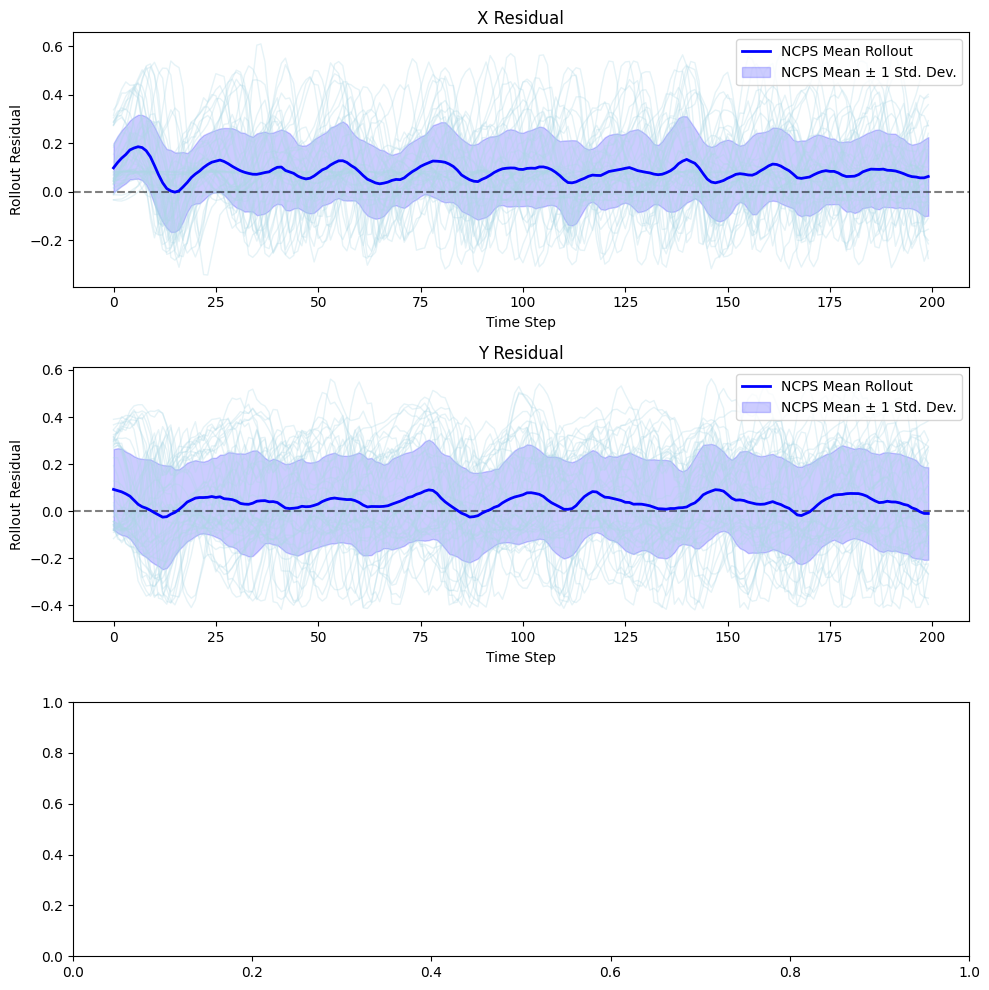

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        #ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')
    #ax.set_ylim(-0.24, 0.24)

    # Compute and plot the mean
    #mean_rollout = res_2.mean(axis=0)
    #ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    #std_rollout = res_2.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
    #               color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, NCPS1_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, NCPS1_y_res, "Y Residual")

# Plot for ang_res
#plot_residuals(axes[2], NCPS_ang_res, 0, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


In [44]:
import torch

n_step_rollout = 200
window_size = 5  # the number of timesteps in each input window

# Suppose t_inputs has shape (B, window_size, input_dim) for the initial burn-in.
cur_input = torch.FloatTensor(t_inputs[:, :window_size, :])  # (B, 5, input_dim)

# Suppose a has shape (B, n_step_rollout, a_dim),
# meaning we have 'n_step_rollout' actions to apply in open-loop fashion.
a = torch.FloatTensor(t_a)  # (B, 100, a_dim)

# Prepare hidden state for CfC with mixed_memory
h0 = torch.zeros((cur_input.shape[0], world_model.state_size), device=cur_input.device)
c0 = torch.zeros((cur_input.shape[0], world_model.state_size), device=cur_input.device)
hx = (h0, c0)

predictions = []

for i in range(n_step_rollout):
    # Forward pass the current 5 timesteps => shape (B, 5, input_dim)
    with torch.no_grad():
        out, hx = world_model(cur_input, hx)  
        # out => shape (B, hidden_dim), since return_sequences=False

    # Collect this step's output for inspection
    # shape => (B, 1, hidden_dim)
    predictions.append(out.unsqueeze(1))

    # Build the new last-timestep that will go into position '4' of the next window
    # (the 0th will be dropped).
    # out => (B, hidden_dim), a[:, i, :] => (B, a_dim)
    # So next_step_input => (B, hidden_dim + a_dim)
    next_step_input = torch.cat([out, a[:, i, :]], dim=-1)

    # next_step_input => (B, 1, hidden_dim + a_dim) so it can be appended
    next_step_input = next_step_input.unsqueeze(1)

    # Drop the oldest timestep (index 0) from cur_input => shape (B, 4, input_dim)
    # Then append the new step => shape (B, 5, input_dim)
    cur_input = torch.cat([cur_input[:, 1:, :], next_step_input], dim=1)

# Finally, stack all predictions => (B, n_step_rollout, hidden_dim)
predictions = torch.cat(predictions, dim=1).numpy()


In [45]:
#print(t_inputs[0, :10, :], "\n", t_outputs[0, :10, :])
#t_inputs.shape
#print(predictions[0, :10, :])

In [46]:
predictions.shape

(50, 200, 2)

[0.29336125 0.67016995 0.2760671  0.8381563  0.63297784 0.703914
 0.7353249  0.01503736 0.77736187 0.21491227 0.03772863 0.5393779
 0.24704249 1.0487696  0.7808571  0.52714247 0.0369322  0.2169854
 0.47034615 0.44771814 0.8641622  0.226744   0.7546261  0.01234652
 0.27923256 0.42935902 1.0480587  0.01722723 0.06872658 0.39502302
 0.48761398 0.9472386  0.01441291 0.7511062  0.21043602 0.60817945
 0.41993797 0.12602863 0.27107704 0.85789347 0.36241773 0.86643875
 0.6601095  0.5330354  0.5314408  1.2165024  0.6543849  0.33822083
 0.6688515  1.0621722 ]


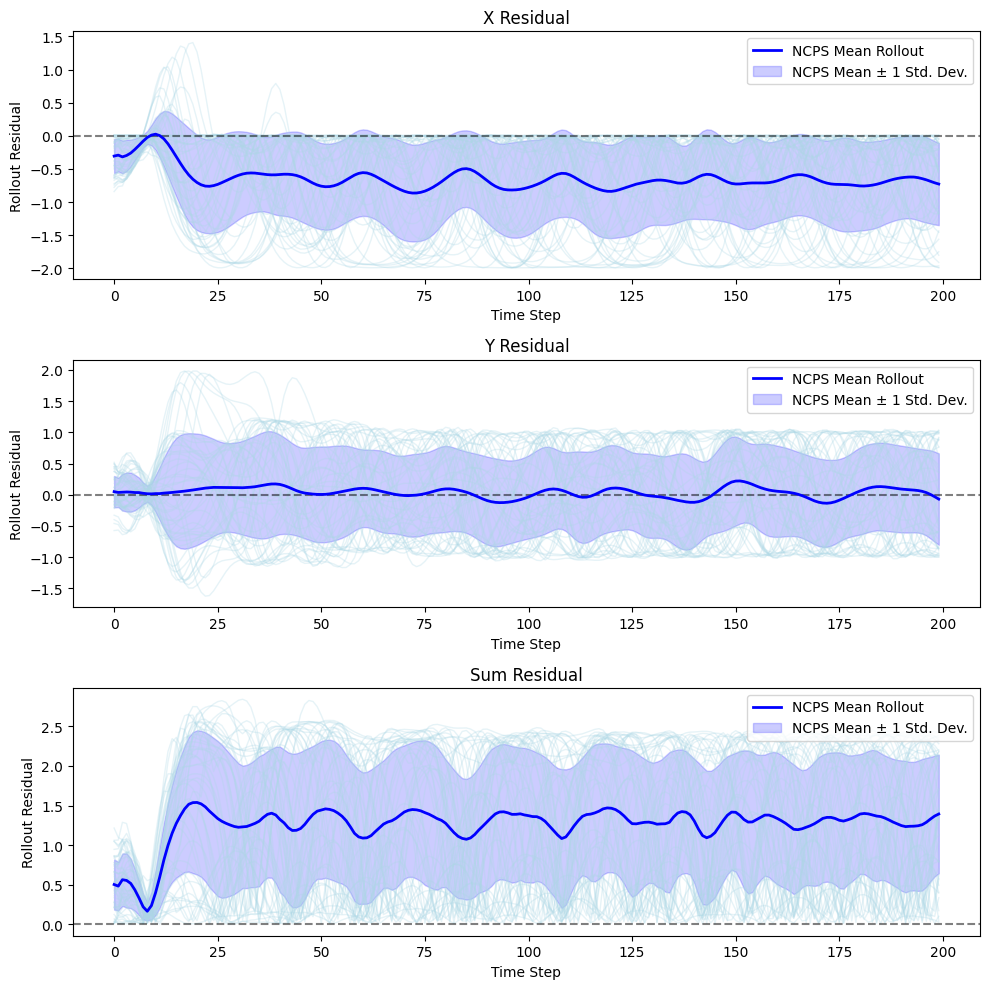

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

NCPS_res = predictions - t_outputs[:, :, :2]
NCPS_total_res = np.sum(np.abs(NCPS_res), axis=-1)
#print(NCPS_res[:, :, 0].shape)
print(NCPS_total_res[:, 0])
# Plot for x_res
plot_residuals(axes[0], NCPS_res[:, :, 0], 0, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_res[:, :, 1], 0, "Y Residual")

# Plot for ang_res
#plot_residuals(axes[2], NCPS_res[:, :, 2], 0, "Angular Velocity Residual")
plot_residuals(axes[2], NCPS_total_res, 0, "Sum Residual")

plt.tight_layout()
plt.show()


### Save model


In [48]:
num_s = str(num_rollouts)
PATH = f"models"
torch.save(world_model, PATH + f"/model_{num_s}.pt")


### Load Model

In [36]:
from ncps.wirings import NCP
out_features = 2
in_features = 3

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=6, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=4, motor_fanin=2)

num_s = str(num_rollouts) # This is how many rollouts we have, in this case it's 100.
PATH = f"models/NCPS_NM_{num_s}"

with open(PATH + '/adj_mat.npy', 'rb') as f:
    adj = np.load(f)

with open(PATH + '/sens_mat.npy', 'rb') as f:
    sens = np.load(f)

wiring.adjacency_matrix = adj
wiring.sensory_adjacency_matrix = sens

NCPS = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "sigmoid", mixed_memory=True) # change to cfc, what could go wrong?
NCPS.load_state_dict(torch.load(PATH+ "/weights", weights_only=True))

<All keys matched successfully>

### PPO Samples

In [71]:
t_obs = []
t_a = []
t_n_obs = []
for _ in range(50):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False

    c_obs = []
    c_a = []
    c_n_obs = []
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation
        v_obs = torch.FloatTensor(observation)

        action, log_prob = agent.get_action(v_obs)
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        c_obs.append(obs)
        c_a.append(action)
        c_n_obs.append(observation)
   
    # Once the episode is done, close the environment
    #env.close()

    t_obs.append(np.vstack(c_obs))
    t_a.append(np.vstack(c_a))
    t_n_obs.append(np.vstack(c_n_obs))

env.close()

t_obs = np.stack(t_obs)
t_a = np.stack(t_a)
t_n_obs = np.stack(t_n_obs)

t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_inputs = np.concatenate((t_obs, t_a), axis=2)

In [220]:
# NCPS Residuals

#t_inputs = t_obs
t_outputs = t_n_obs

x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T
NCPS_ang_res = np.stack(ang_vel_residuals).T

In [221]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    #c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    prediction = np.array(DNN_world_model.predict([t_inputs[:, i,:3],
                                      np.zeros((50,3)),
                                      t_inputs[:, i,3:]])).squeeze()

    # add residuals
    #prediction = t_outputs[:, i, :] + prediction
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━

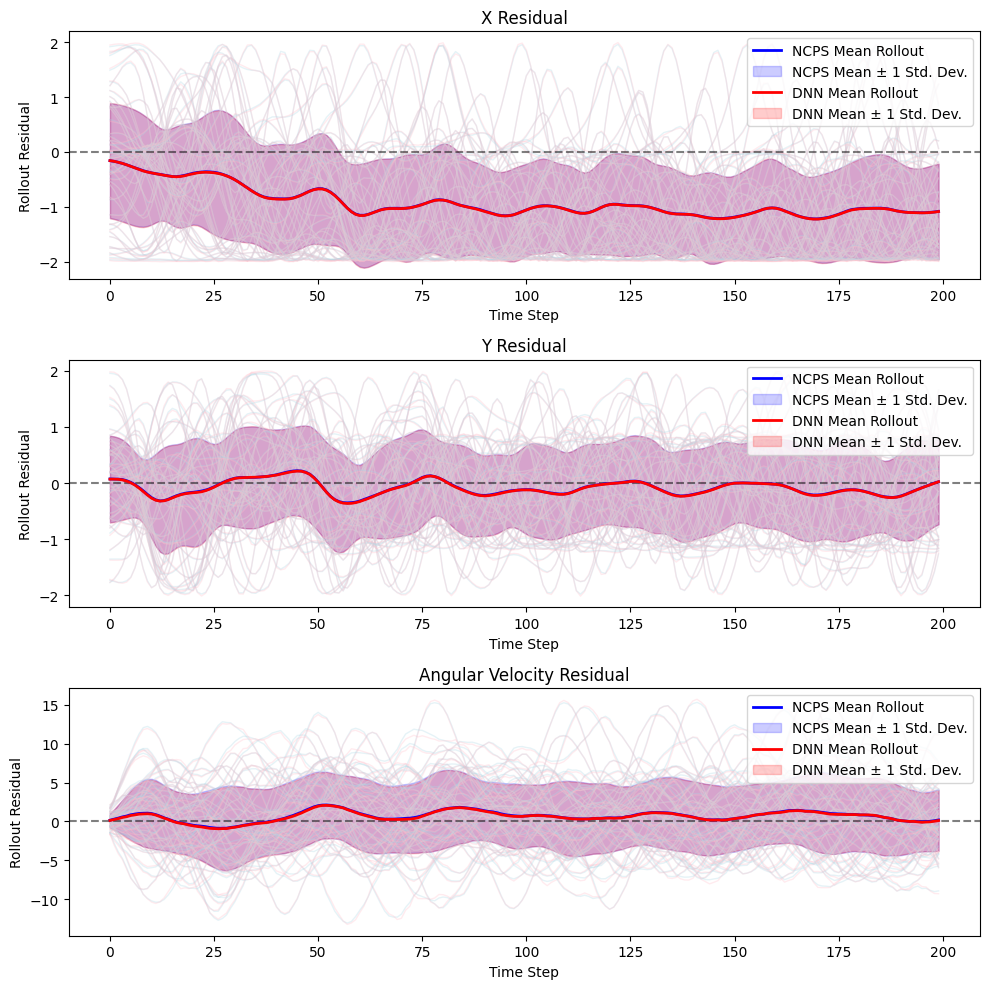

In [222]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_ang_res, DNN_ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


### 50 Samples Trajectories

In [223]:
inputs, outputs = get_rnd_env_samples(env, 50)

set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = torch.FloatTensor(time_horizon[-1])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2] - outputs[:, i, 2])

    #print(c_inputs)
    #print(prediction)

    res = prediction - outputs[:, i+1, :]

    #print("residuals: ", res)

    set_of_residuals.append(np.sum(np.abs(prediction - outputs[:, i, :]), axis=1))

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)


x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T
set_of_res = np.stack(set_of_residuals).T
ang_res.shape

(50, 150)

In [224]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []
set_of_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = time_horizon[-1]
    zeros = np.zeros((50, 3))
    #print(c_inputs.shape)
    prediction = DNN_world_model((c_inputs[:, :3],zeros, c_inputs[:, 3]))
    prediction = np.array(prediction).squeeze()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2] - outputs[:, i, 2])
    set_of_residuals.append(np.sum(np.abs(prediction - outputs[:, i, :]), axis=1))

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T
DNN_res = np.stack(set_of_residuals).T

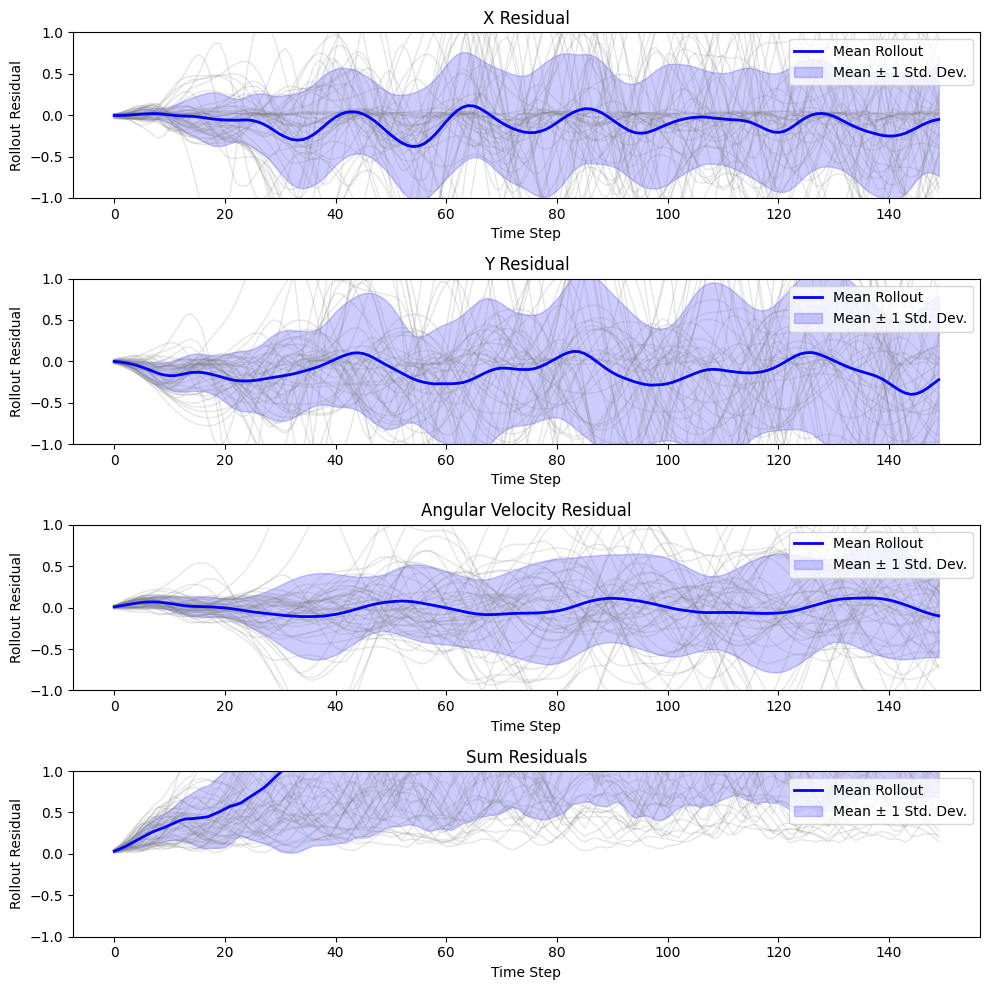

In [225]:
# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    ax.set_ylim(-1, 1)
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plot_residuals(axes[3], set_of_res, "Sum Residuals")

plt.tight_layout()
plt.show()


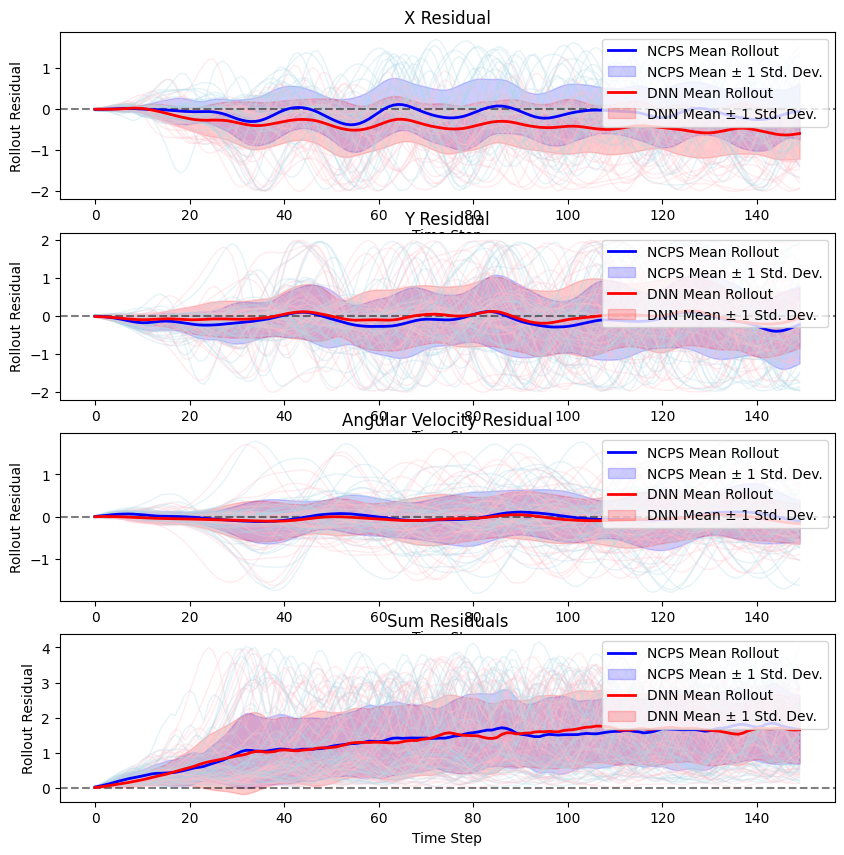

In [226]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, DNN_ang_res, "Angular Velocity Residual")

# Plot for total res
plot_residuals(axes[3], set_of_res, DNN_res, "Sum Residuals")



In [ ]:
# backburner code
x_ins = []
y_ins = []
a_ins = []
traj_len = 3
look_ahead = 0 
for i in range(num_rollouts - traj_len):
    x_ins.append(s[:, i:i+1, :])
    a_ins.append(a[:, i+1:i+traj_len, :])
    y_ins.append(n_s[:, i:i+traj_len, :])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x_ins).swapaxes(0, 1)
data_a = np.stack(a_ins).swapaxes(0, 1)
data_a = np.stack(a_ins).reshape(-1, traj_len, 1)
print(data_a.shape)
data_x = data_x.reshape(-1, 1, 4)
print(data_x.shape)
data_y = np.stack(y_ins).swapaxes(0, 1)
data_y.shape
data_y = data_y.reshape(-1, traj_len, 3)
data_y.shape